# Age Estimation using CNN Age Classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import shutil

import copy

from pathlib import Path
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

## Age estimation in age groups

### Set image size and variables 

In [2]:
IMAGE_SIZE = [200,200]
BASE_DIR = './UTKFace/'
NR_EPOCHS = 80
BATCH_SIZE = 30
hard_example_ratio = [0.7, 0.5, 0.3]
NUM_CLASSES = 116 

### Split Dataset into validation and test set  

In [3]:
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [file for file in os.listdir(root_dir) if file.endswith('.jpg') or file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        
        age = int(self.images[idx].split('_')[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, age

# transform
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load dataset
full_dataset = UTKFaceDataset(root_dir=BASE_DIR, transform=transform)

# split dataset accordingly 
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# fixed seed for same split across models
generator = torch.Generator().manual_seed(116)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

In [4]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print size information
print(f"Total dataset size: {total_size}")
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 23708
Train set size: 16595
Validation set size: 3556
Test set size: 3557


### Set cuda if aviable

In [5]:
# check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Base Model

### Create Model

In [6]:
class CNNNet(nn.Module):
    def __init__(self, num_classes=116):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(96),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(384),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
# instantiate models
model1 = CNNNet(NUM_CLASSES).to(device)
model2 = CNNNet(NUM_CLASSES).to(device)
model3 = CNNNet(NUM_CLASSES).to(device)

In [8]:
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.0001, momentum=0.9)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.0001, momentum=0.9)

loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
loss_fn = loss_fn.to(device)

# define age_classes tensor
age_classes = torch.tensor([i for i in range(1, NUM_CLASSES + 1)]).to(device)

### Train modeln with OHEM

In [9]:
def train(model, pre_trained_model, optimizer, loss_fn, train_loader, val_loader, epochs, summary_writer, device, hard_example_ratio, save_path):
    
    # create history for graphs
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': [],
        'mae': [],
        'val_mae': []
    }
    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    # init variables for saving
    best_val_mae = float('Inf') 
    best_model_wts = copy.deepcopy(model.state_dict()) 
    pre_trained_model.eval()
    
    start.record()
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        num_train = 0
        num_train_correct = 0
        total_train_mae = 0.0
        total_val_mae = 0.0
        
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            # shift for loss 
            targets_model = targets - 1
            inputs, targets_model = inputs.to(device), targets_model.to(device)
            targets = targets.to(device)

            with torch.no_grad():
                outputs = pre_trained_model(inputs)
                per_sample_loss = loss_fn(outputs, targets_model)
            
            num_hard_examples = max(1, int(inputs.size(0) * hard_example_ratio))                           
            _, hard_indices = torch.topk(per_sample_loss, num_hard_examples)
            
            hard_inputs = inputs[hard_indices]
            hard_targets_model = targets_model[hard_indices]
            hard_targets = targets[hard_indices]
            
            hard_outputs = model(hard_inputs)
            loss = loss_fn(hard_outputs, hard_targets_model)
            loss = loss.mean()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            _, predicted = hard_outputs.max(1)
            predicted = predicted + 1
            num_train += hard_targets.size(0)
            num_train_correct += predicted.eq(hard_targets).sum().item()
            
            
            probabilities = F.softmax(hard_outputs, dim=1)
            expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
            total_train_mae += torch.abs(expected_age - hard_targets.float()).sum().item()
              
        training_loss /= len(train_loader)
        train_accuracy = num_train_correct / num_train
        train_mae = total_train_mae / num_train

        if epoch+1 == NR_EPOCHS:
            end.record()
            torch.cuda.synchronize()
        
        model.eval()
        num_val = 0
        num_val_correct = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                targets_model = targets - 1
                inputs, targets_model = inputs.to(device), targets_model.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                
                loss = loss_fn(outputs, targets_model)
                loss = loss.mean()
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                predicted = predicted + 1
                num_val += targets.size(0)
                num_val_correct += predicted.eq(targets).sum().item() 

                probabilities = F.softmax(outputs, dim=1)
                expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
                total_val_mae += torch.abs(expected_age - targets.float()).sum().item()
        
        valid_loss /= len(val_loader)
        val_accuracy = num_val_correct / num_val
        val_mae = total_val_mae / num_val

        summary_writer.add_scalar('Train Loss', training_loss, epoch+1)
        summary_writer.add_scalar('Val Loss', valid_loss, epoch+1)
        summary_writer.add_scalar('Accuracy', train_accuracy, epoch+1)
        summary_writer.add_scalar('Validation Accuracy', val_accuracy, epoch+1)
        summary_writer.add_scalar('Train MAE', train_mae, epoch+1)
        summary_writer.add_scalar('Val MAE', val_mae, epoch+1)
    
        history['loss'].append(training_loss)
        history['val_loss'].append(valid_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        print(f'Epoch [{epoch+1}/{NR_EPOCHS}], Training Loss: {training_loss:.2f}, Validation Loss: {valid_loss:.2f}, '
              f'Training Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}, Training MAE: {train_mae:.2f}, Validation MAE: {val_mae:.2f}')
        
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"Best model saved at epoch {epoch+1} with validation MAE: {best_val_mae:.2f}")

    print(f'Training time:  {round(start.elapsed_time(end), 1) / 60000} minutes')    
    return history

### Train models

#### OHEM 0.7

In [10]:
#load pre-trained read-only net
pre_trained_model = CNNNet(NUM_CLASSES).to(device)
pre_trained_model.load_state_dict(torch.load('./Project/classes/normal/normal_model'))

writer1 = SummaryWriter('./Project/class_imbalance/runs/ohem1', comment='OHEM_Model1')
history1 = train(model1, pre_trained_model, optimizer1, loss_fn, train_loader, val_loader, NR_EPOCHS, writer1, device, hard_example_ratio[0], './Project/class_imbalance/ohem/age_class_1')
writer1.close()

Epoch [1/80], Training Loss: 4.75, Validation Loss: 4.74, Training Accuracy: 0.01, Validation Accuracy: 0.02, Training MAE: 25.15, Validation MAE: 28.64
Best model saved at epoch 1 with validation MAE: 28.64
Epoch [2/80], Training Loss: 4.73, Validation Loss: 4.72, Training Accuracy: 0.02, Validation Accuracy: 0.02, Training MAE: 24.89, Validation MAE: 28.28
Best model saved at epoch 2 with validation MAE: 28.28
Epoch [3/80], Training Loss: 4.70, Validation Loss: 4.70, Training Accuracy: 0.03, Validation Accuracy: 0.02, Training MAE: 24.58, Validation MAE: 27.85
Best model saved at epoch 3 with validation MAE: 27.85
Epoch [4/80], Training Loss: 4.68, Validation Loss: 4.67, Training Accuracy: 0.03, Validation Accuracy: 0.02, Training MAE: 24.13, Validation MAE: 27.24
Best model saved at epoch 4 with validation MAE: 27.24
Epoch [5/80], Training Loss: 4.64, Validation Loss: 4.64, Training Accuracy: 0.03, Validation Accuracy: 0.03, Training MAE: 23.52, Validation MAE: 26.47
Best model save

#### OHEM 0.5

In [11]:
writer2= SummaryWriter('./Project/class_imbalance/runs/ohem2', comment='OHEM_Model2')
history2 = train(model2, pre_trained_model, optimizer2, loss_fn, train_loader, val_loader, NR_EPOCHS, writer2, device, hard_example_ratio[1], './Project/class_imbalance/ohem/age_class_2')
writer2.close()

Epoch [1/80], Training Loss: 4.75, Validation Loss: 4.75, Training Accuracy: 0.01, Validation Accuracy: 0.01, Training MAE: 23.83, Validation MAE: 28.68
Best model saved at epoch 1 with validation MAE: 28.68
Epoch [2/80], Training Loss: 4.74, Validation Loss: 4.74, Training Accuracy: 0.02, Validation Accuracy: 0.02, Training MAE: 23.53, Validation MAE: 28.35
Best model saved at epoch 2 with validation MAE: 28.35
Epoch [3/80], Training Loss: 4.72, Validation Loss: 4.73, Training Accuracy: 0.02, Validation Accuracy: 0.02, Training MAE: 23.30, Validation MAE: 27.97
Best model saved at epoch 3 with validation MAE: 27.97
Epoch [4/80], Training Loss: 4.70, Validation Loss: 4.72, Training Accuracy: 0.02, Validation Accuracy: 0.02, Training MAE: 22.98, Validation MAE: 27.49
Best model saved at epoch 4 with validation MAE: 27.49
Epoch [5/80], Training Loss: 4.67, Validation Loss: 4.71, Training Accuracy: 0.02, Validation Accuracy: 0.02, Training MAE: 22.55, Validation MAE: 26.90
Best model save

#### OHEM 0.3

In [12]:
writer3 = SummaryWriter('./Project/class_imbalance/runs/ohem3', comment='OHEM_Model3')
history3 = train(model3, pre_trained_model, optimizer3, loss_fn, train_loader, val_loader, NR_EPOCHS, writer3, device, hard_example_ratio[2], './Project/class_imbalance/ohem/age_class_3')
writer3.close()

Epoch [1/80], Training Loss: 4.75, Validation Loss: 4.75, Training Accuracy: 0.01, Validation Accuracy: 0.01, Training MAE: 22.96, Validation MAE: 28.75
Best model saved at epoch 1 with validation MAE: 28.75
Epoch [2/80], Training Loss: 4.74, Validation Loss: 4.75, Training Accuracy: 0.02, Validation Accuracy: 0.01, Training MAE: 22.81, Validation MAE: 28.56
Best model saved at epoch 2 with validation MAE: 28.56
Epoch [3/80], Training Loss: 4.72, Validation Loss: 4.75, Training Accuracy: 0.02, Validation Accuracy: 0.01, Training MAE: 22.70, Validation MAE: 28.31
Best model saved at epoch 3 with validation MAE: 28.31
Epoch [4/80], Training Loss: 4.71, Validation Loss: 4.75, Training Accuracy: 0.02, Validation Accuracy: 0.01, Training MAE: 22.47, Validation MAE: 27.97
Best model saved at epoch 4 with validation MAE: 27.97
Epoch [5/80], Training Loss: 4.70, Validation Loss: 4.75, Training Accuracy: 0.02, Validation Accuracy: 0.01, Training MAE: 22.28, Validation MAE: 27.61
Best model save

## Training History

In [13]:
def plot_history(history, path_name):
    # loss
    loss_train = history['loss']
    loss_val = history['val_loss']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path_name + '_loss.png', bbox_inches='tight')
    plt.show()
    

    # mae
    train_mae = history['mae']
    val_mae = history['val_mae']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, train_mae, 'g', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.savefig(path_name + '_MAE.png', bbox_inches='tight')
    plt.show()
   


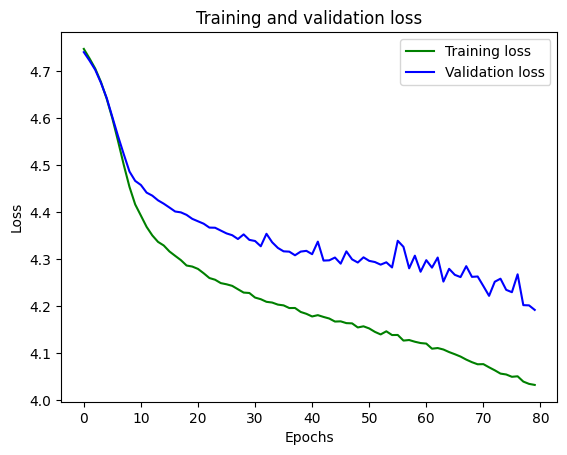

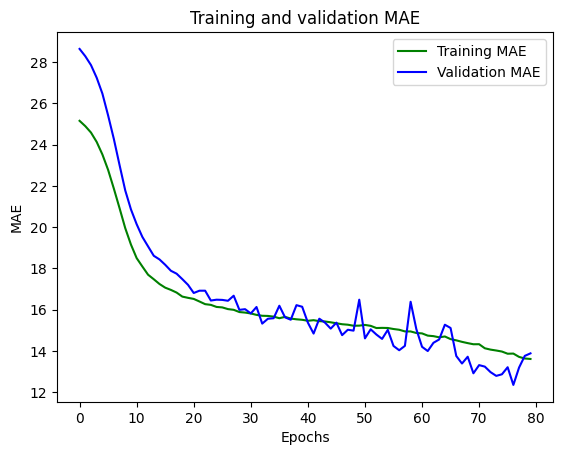

In [14]:
plot_history(history1, './Project/class_imbalance/ohem/age_class_1')

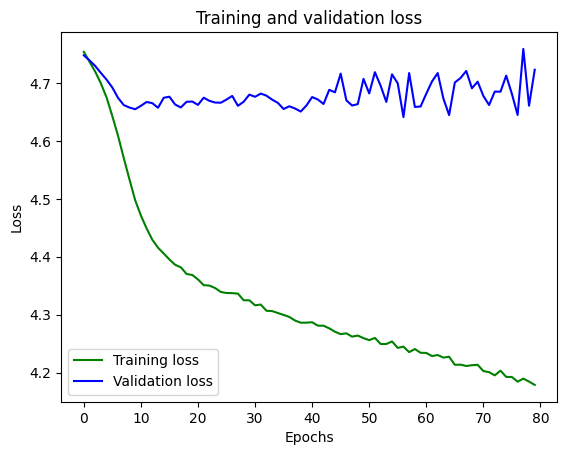

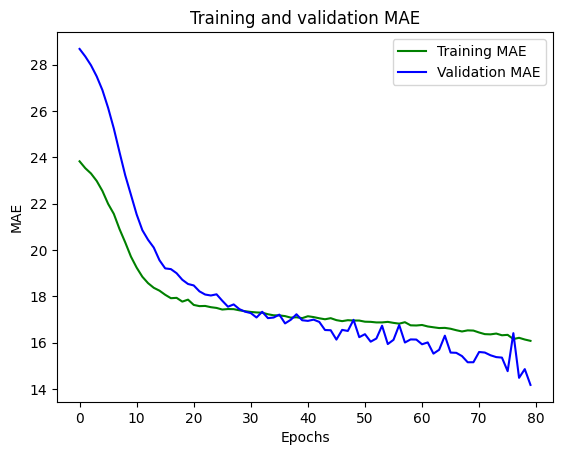

In [15]:
plot_history(history2, './Project/class_imbalance/ohem/age_class_2')

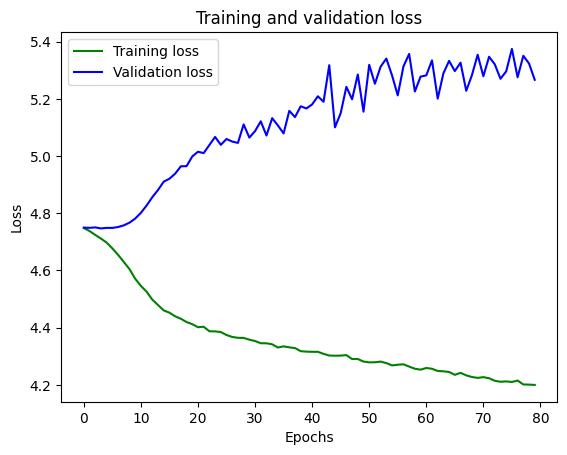

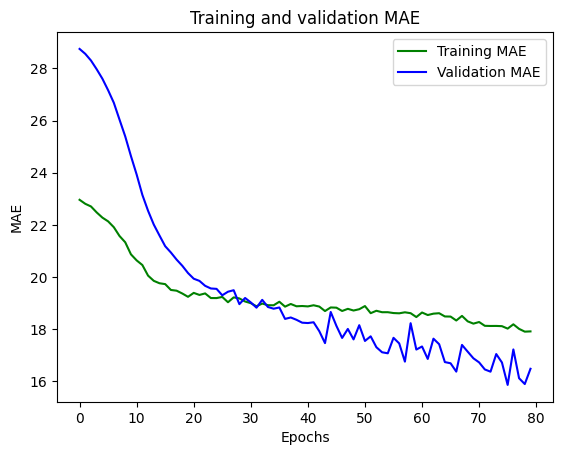

In [16]:
plot_history(history3, './Project/class_imbalance/ohem/age_class_3')

### Test Model

In [17]:
def test(model, test_loader, loss_fn ,name):
    test_loss = 0
    test_correct = 0
    test_total = 0
    total_test_mae = 0
    
    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    model.eval()
    start.record()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # shift labels from 1-116 to 0-115 for loss
            labels_model = labels - 1
            inputs, labels_model = inputs.to(device), labels_model.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels_model)

            test_loss += loss.mean().item()
            _, predicted = outputs.max(1)
            predicted = predicted + 1
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

            probabilities = F.softmax(outputs, dim=1)
            expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
            total_test_mae += torch.abs(expected_age - labels.float()).sum().item()   

    end.record()
    torch.cuda.synchronize()
    test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total
    test_mae = total_test_mae / test_total

    print(f'Model: {name},  Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}, Test MAE: {test_mae:.2f}')
    print(f'Time:  {round(start.elapsed_time(end), 1) / 1000} seconds')

In [18]:
# load models
model_ohem1 = CNNNet().to(device)
model_ohem1.load_state_dict(torch.load('./Project/class_imbalance/ohem/age_class_1'))

model_ohem2 = CNNNet().to(device)
model_ohem2.load_state_dict(torch.load('./Project/class_imbalance/ohem/age_class_2'))

model_ohem3 = CNNNet().to(device)
model_ohem3.load_state_dict(torch.load('./Project/class_imbalance/ohem/age_class_3'))


test(model_ohem1, test_loader, loss_fn, 'OHEM topK 0.7')
test(model_ohem2, test_loader, loss_fn, 'OHEM topK 0.5')
test(model_ohem3, test_loader, loss_fn, 'OHEM topK 0.3')

Model: OHEM topK 0.7,  Test Loss: 4.31, Test Accuracy: 0.03, Test MAE: 12.58
Time:  8.692 seconds
Model: OHEM topK 0.5,  Test Loss: 4.78, Test Accuracy: 0.02, Test MAE: 14.30
Time:  8.0923 seconds
Model: OHEM topK 0.3,  Test Loss: 5.42, Test Accuracy: 0.01, Test MAE: 15.87
Time:  8.008899999999999 seconds
